<a href="https://colab.research.google.com/github/PhamMinhTien05102001/Shopee-Code-League-2020-Data-Science/blob/main/Method_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import random
import os
import math
import sklearn
import cv2
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import matplotlib
import tensorflow as tf
import itertools
from tensorflow.python.keras.layers import Dense, Dropout, Flatten, GlobalAvgPool2D, Conv2D, MaxPool2D
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from tensorflow.python.keras.models import Model, Sequential
from sklearn.model_selection import train_test_split
from tensorflow.python.keras.applications.vgg16 import VGG16

In [ ]:
AUTO = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 64
IMAGE_SIZE = (512, 512)
path_model = "model"

**LOAD DỮ LIỆU SỬ DỤNG FILE TFRECORDS**

In [ ]:
GCS_TRAIN_PATHS = [
    '/content/drive/MyDrive/project/tfrecords',
    '/content/drive/MyDrive/project/tfrecords2'
]

TRAINING_FILENAMES = []
for i in GCS_TRAIN_PATHS:
    print(i)
    TRAINING_FILENAMES.append(tf.io.gfile.glob(i + '/*.tfrecords'))  
TRAINING_FILENAMES = list(itertools.chain.from_iterable(TRAINING_FILENAMES))
print(len(TRAINING_FILENAMES))

**ĐỌC DỮ LIỆU TỪ FILE TFRECORDS TRẢ VỀ ẢNH VÀ LABEL TƯƠNG ỨNG**


> decode_image : Đọc dữ liệu từ image_data(kiểu string) sau đó trả về ma trận ảnh với kích thước (128, 128, 3)

> read_label_tfrecord : Đọc dữ liệu từ file và trả về (image, label), mỗi lần ta chỉ train trên 21 label

In [ ]:
def decode_image(image_data):
    img = tf.image.decode_jpeg(image_data, channels=3)
    img = tf.cast(img, tf.float32) / 255.0
    img = tf.reshape(img, [*IMAGE_SIZE, 3])
    print(type(img))
    img = tf.image.resize(img, (128,128))
    return img

def read_label_tfrecord(example):
    FORMAT = {
        "image" : tf.io.FixedLenFeature([], tf.string),
        "label" : tf.io.FixedLenFeature([], tf.int64)
    }
    example = tf.io.parse_single_example(example, FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['label'], tf.int32)        # Model 1 : From "00" to "20"
    # label = tf.cast(example['label'], tf.int32) - 21 # Model 2 :From "21" to "41" transform to "00" -> "20"
    return (image, label)

def load_dataset(filenames):
    Order = tf.data.Options()
    Order.experimental_deterministic = True
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
    print(AUTO)
    dataset = dataset.with_options(Order)

    def choice_label(image, label):
      return label < 21    #Model 1 : From "00" to "20"
      # return label >= 0  #Model 2 : From "21" to "41" transform to "00" -> "20"

    dataset = dataset.map(read_label_tfrecord).filter(choice_label)
    return dataset

In [ ]:
vanilla_training_ds = load_dataset(TRAINING_FILENAMES)
print(vanilla_training_ds)

In [ ]:
def print_target_counts(y):
    _, y_counts = np.unique(y, return_counts=True)
    y_total = len(y)
    print("Total", y_total)
    k = 0
    number_in_label = []
    for i in range(max(y)+1):
        print(k, " : ", y_counts[i])
        k += 1


In [ ]:
y_targets = np.array([target.numpy() for _, target in iter(vanilla_training_ds)]) 

**SỐ LƯỢNG ẢNH TRONG TỪNG LABE**

In [ ]:
x_indicies = np.arange(len(y_targets))
print_target_counts(y_targets)

Total 53729
0  :  2683
1  :  2706
2  :  2691
3  :  2704
4  :  2705
5  :  2645
6  :  2646
7  :  2660
8  :  2704
9  :  2700
10  :  2675
11  :  1848
12  :  2694
13  :  2686
14  :  2686
15  :  2633
16  :  2665
17  :  1555
18  :  2106
19  :  2681
20  :  2656


**CHIA DATA THÀNH 2 TẬP TRAIN VÀ VALIDATION THEO TỈ LỆ 4:1**

In [ ]:
x_train_indices, x_val_indicies, y_train_targets, y_val_targets = train_test_split(x_indicies, y_targets, 
                                                                                   test_size=0.2, random_state=100)
print_target_counts(y_train_targets)
print_target_counts(y_val_targets)

Total 42983
0  :  2126
1  :  2165
2  :  2146
3  :  2137
4  :  2176
5  :  2114
6  :  2107
7  :  2154
8  :  2191
9  :  2166
10  :  2154
11  :  1515
12  :  2107
13  :  2100
14  :  2130
15  :  2108
16  :  2134
17  :  1275
18  :  1675
19  :  2158
20  :  2145
Total 10746
0  :  557
1  :  541
2  :  545
3  :  567
4  :  529
5  :  531
6  :  539
7  :  506
8  :  513
9  :  534
10  :  521
11  :  333
12  :  587
13  :  586
14  :  556
15  :  525
16  :  531
17  :  280
18  :  431
19  :  523
20  :  511


In [ ]:
def get_selected_dataset(ds, X_indices_np):
    X_indices_ts = tf.constant(X_indices_np, dtype=tf.int64)
    def is_index_in(index, rest):
        return tf.math.reduce_any(index == X_indices_ts)
    def drop_index(index, rest):
        return rest
    selected_ds = ds.enumerate().filter(is_index_in).map(drop_index)
    return selected_ds

In [ ]:
splitted_train_ds = get_selected_dataset(vanilla_training_ds,
                                        x_train_indices)
sliptted_val_ds = get_selected_dataset(vanilla_training_ds,
                                      x_val_indicies)

In [ ]:
def get_training_dataset():
    dataset = splitted_train_ds
    dataset = dataset.repeat()
    dataset = dataset.shuffle(1500)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset
def get_validation_dataset():
    dataset = sliptted_val_ds
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO)
    return dataset

**TẠO MODEL SỬ DỤNG TRANSFER LEARNING VGG16**

> Lấy lại trọng số đã train qua tập dữ liệu imagenet, sau đó cho train tiếp tục từ tập trọng số này

> Thay đổi lớp FC cho phù hợp với lượng dữ liệu

> Model có 15,832,149 tham số



In [ ]:
NUM_TRAINING_IMAGES = len(y_train_targets)
NUM_VALIDATION_IMAGES = len(y_val_targets)
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE
print('Dataset: {} training images, {} validation images'.format(
    NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES))
print("step_per_epoch", STEPS_PER_EPOCH)

Dataset: 42983 training images, 10746 validation images
step_per_epoch 671


In [ ]:
def get_model_vgg():
    vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
    for layer in vgg16.layers:
        layer.trainable = True

    model = vgg16.output
    model = MaxPool2D(pool_size=(2, 2), strides=(2, 2))(model)
    model = Flatten()(model)
    model = Dropout(0.5)(model)
    model = Dense(512, activation='relu')(model)
    model = Dropout(0.2)(model)
    model = Dense(128, activation='relu')(model)
    model = Dense(21, activation='softmax')(model)
    
    my_model_vgg16 = Model(inputs=vgg16.input, outputs=model)
    my_model_vgg16.compile(optimizer="adam", loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return my_model_vgg16

**ĐỒ THỊ ACCURACY, LOSS TRÊN CẢ 2 TẬP TRAIN VÀ VALIDATION**

In [ ]:
def plot_model_history(model_history, start=10, validation_freq=2, acc='accuracy', val_acc='val_accuracy'):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    axs[0].set_title("Model Accuracy")
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[1].set_title("Model Loss")
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')


    axs[0].plot(range(start, len(model_history.history[acc]) + 1), model_history.history[acc][(start-1):], 'o-')
    axs[1].plot(range(start, len(model_history.history['loss']) + 1), model_history.history['loss'][(start-1):], 'o-')

    i = 1
    val_acc_points = []
    epoch = []
    for val_accuracy in model_history.history[val_acc]:
      val_acc_points.append(val_accuracy)
      epoch.append(i * validation_freq)
      i += 1
    axs[0].plot(epoch, val_acc_points, 'o-')

    val_loss_points = []
    for val_loss in model_history.history['val_loss']:
      val_loss_points.append(val_loss)
    axs[1].plot(epoch, val_loss_points, 'o-')

    axs[0].legend(['train', 'val'])
    axs[1].legend(['train', 'val'])
    plt.plot()

**ĐỒ THỊ LEARNING_RATE THAY ĐỔI THEO TỪNG EPOCH TRONG QUÁ TRÌNH TRAIN**

In [ ]:
def plt_lr(epoch_count):    
    if epoch_count > 50:
        epoch_count = 50
    
    rng = [i for i in range(epoch_count)]

    plt.figure()
    y = [lrfn(x) for x in rng]
    plt.title(f'Learning rate schedule: {y[0]} to {y[epoch_count-1]}')
    plt.plot(rng, y)

In [ ]:
def lrfn(epoch):
  initial_lrate = 0.0001
  drop = 0.8
  epochs_drop = 2
  lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
  return lrate

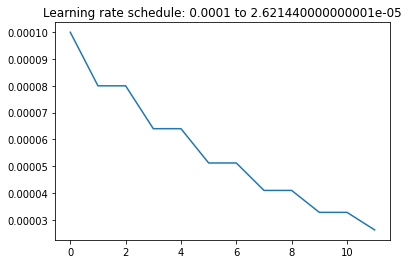

In [ ]:
plt_lr(12)

**KHỞI TẠO CÁC CALLBACK TRONG QUÁ TRÌNH HỌC CỦA MODEL**


> model_checkpoint : Lưu lại trọng số model sau mỗi epoch có val_accuracy đạt max

> lr_schedule : Điều chỉnh learning_rate theo hàm lrfn đã định nghĩa ở trên





In [ ]:
model_checkpoint = ModelCheckpoint('model_checkpoint', monitor='val_accuracy',
                                  verbose=1, save_best_only=True, model='max', save_weights_only=True)
lr_schedule = LearningRateScheduler(lrfn, verbose=True)

**GỌI MODEL VÀ CHO MODEL TRAIN**

In [ ]:
my_model = get_model_vgg()
my_model.summary()

In [ ]:
history = my_model.fit(
    get_training_dataset(), steps_per_epoch=STEPS_PER_EPOCH,
    epochs=12,verbose=1, validation_data=get_validation_dataset(),validation_freq=2,
    callbacks=[model_checkpoint, lr_schedule] 
    )

**LƯU VÀ HIỂN THỊ KẾT QUẢ SAU KHI TRAIN MODEL**

In [ ]:
my_model.save("model/vgg16_21label(0-20).h5")   #Save model 1
#my_model.save("model/vgg16_21label(21-41).h5")  #Save model 2

In [ ]:
plot_model_history(history, 1, 2)
plt.savefig('vgg16_21label(0-20).png')    #Save image result model 1
#plt.savefig('vgg16_21label(21-41).png')   #Save image result model 2